In [1]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

# Optimization with 3 stations

## Load forcing


In [2]:
latitude_hot = 22.75
longitude_hot = -158

Load forcing.


In [3]:
time_start, time_end = "2000-01-01", "2022-01-01"

data = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Hot_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [6]:
def update_layer(data: xr.DataArray, epipelagic_size):
    """Multiply biomass density of observation by the 150m which is the average epipelagic layer depth."""
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")

obs_hot = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Hot_climato.zarr", engine="zarr")
obs_hot = update_layer(obs_hot, epipelagic_size.sel(latitude=latitude_hot, longitude=longitude_hot))
obs_hot["day"] = obs_hot["day"] + obs_hot["day_trend"]
obs_hot["night"] = obs_hot["night"] + obs_hot["night_trend"]
obs_hot = Observation(obs_hot)

observations = [obs_hot]

Create structure for SeapoPym simulation.


In [7]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-12-18 13:58:23,864 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [8]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [9]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [10]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=400,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [11]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [12]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53779 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [13]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53779/status,
Dashboard: http://127.0.0.1:53779/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53780,Workers: 4
Dashboard: http://127.0.0.1:53779/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53792,Total threads: 2
Dashboard: http://127.0.0.1:53795/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53783,


## Run the optimization


In [14]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,528.379871,1615.058400,0.063737,21269.999238,269,0.000000
1,268.396917,1244.142013,0.036603,21146.605529,381,0.149606
2,46.542710,366.862153,0.041722,5994.967861,390,0.220513
3,7.664267,47.517335,0.039051,788.003314,397,0.186398
4,1.439014,5.618056,0.037045,67.843452,398,0.180905
5,1.873878,7.767484,0.037045,100.134435,399,0.162907
6,1.128524,6.268149,0.040727,98.030080,399,0.205514
7,0.867400,4.838173,0.037165,76.214130,398,0.185930
8,1.126158,8.918169,0.037318,159.502984,400,0.140000


## Plot the results


In [15]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,528.379871,1615.058400,0.063737,21269.999238,269,0.000000
1,268.396917,1244.142013,0.036603,21146.605529,381,0.149606
2,46.542710,366.862153,0.041722,5994.967861,390,0.220513
3,7.664267,47.517335,0.039051,788.003314,397,0.186398
4,1.439014,5.618056,0.037045,67.843452,398,0.180905
5,1.873878,7.767484,0.037045,100.134435,399,0.162907
6,1.128524,6.268149,0.040727,98.030080,399,0.205514
7,0.867400,4.838173,0.037165,76.214130,398,0.185930
8,1.126158,8.918169,0.037318,159.502984,400,0.140000


In [16]:
viewer.logbook

D1N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.193627   
                               1                          0.659252   
                               2                          0.197069   
                               3                          0.604057   
                               4                          0.569382   
...                                                            ...   
10         True                363                        0.163138   
                               376                        0.207663   
                               377                        0.173985   
                               384                        0.207663   
                               385                        0.207663   

                                           D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    180.510137   
                               1                    494.477456   
                               2                    304.659833   
                               3                     12.272882   
                               4                    221.183779   
...                                                        ...   
10         True                363                  396.918869   
                               376                  159.155010   
                               377                  279.786245   
                               384                  396.918869   
                               385                  317.539106   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.115711   
                               1                       0.152316   
                               2                       0.062203   
                               3                       0.136234   
                               4                       0.120505   
...                                                         ...   
10         True                363                     0.170793   
                               376                     0.139297   
                               377                     0.170889   
                               384                     0.175160   
                               385                     0.170793   

                                           D2N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.644757   
                               1                          0.271850   
                               2                          0.308859   
                               3                          0.737792   
                               4                          0.429685   
...                                                            ...   
10         True                363                        0.094738   
                               376                        0.605458   
                               377                        0.333174   
                               384                        0.155552   
                               385                        0.070395   

                                           D2N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    130.030740   
                               1                    284.092402   
                               2                    407.884848   
                               3                    320.328655   
                               4                     93.600149   
...                         

In [33]:
viewer.hall_of_fame.head(20)

,,D1N1_energy_coefficient,D1N1_inv_lambda_max,D1N1_inv_lambda_rate,D2N1_energy_coefficient,D2N1_inv_lambda_max,D2N1_inv_lambda_rate,fitness
generation,individual,,,,,,,
9,57,0.061326,128.174072,0.069894,0.066194,70.758325,0.079991,0.035525
10,54,0.061326,136.106948,0.069894,0.066194,236.642530,0.168742,0.036283
1,263,0.107458,144.910476,0.098001,0.058880,104.283955,0.112656,0.036603
4,136,0.173985,76.183276,0.098001,0.058880,463.685533,0.166665,0.037045
7,245,0.173985,76.183276,0.098001,0.058880,223.632030,0.137802,0.037165
10,145,0.261727,25.498530,0.064792,0.123858,145.015418,0.159903,0.037318
7,346,0.261727,25.498530,0.064792,0.123858,145.015418,0.159903,0.037318
3,290,0.163138,76.183276,0.098001,0.058880,463.685533,0.166665,0.039051
8,319,0.061326,128.174072,0.069894,0.066194,236.642530,0.168742,0.039346


In [18]:
viewer.fitness_evolution()

In [19]:
viewer.box_plot(3)

In [35]:
fig = viewer.parallel_coordinates(500, unselected_opacity=0)
fig.update_layout(width=1000, height=700)

# Generate plots at each station


In [38]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from seapopym_optimization import wrapper

In [39]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {best_individual}")

Best individual: [[ 1.00000000e+00  1.00000000e+00  6.13264159e-02  1.03800000e+01
  -1.10000000e-01  1.28174072e+02  6.98935093e-02]
 [ 2.00000000e+00  1.00000000e+00  6.61935614e-02  1.03800000e+01
  -1.10000000e-01  7.07583250e+01  7.99909693e-02]]


In [40]:
# best_individual = [
#     [1, 1, 0.09, 10.38, -0.11, 50, 0.08],
#     [2, 1, 0.12, 10.38, -0.11, 60, 0.13],
# ]

In [41]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        best_individual,
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

In [42]:
def plot_comparison_to_station(
    obs_1: pd.Series,
    model_1: pd.Series,
    obs_2: pd.Series,
    model_2: pd.Series,
    station_name: str,
    subplot_titles: tuple = ("D1N1", "D2N1"),
    *,
    obs_as_marker: bool = False,
):
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=subplot_titles,
        shared_xaxes=True,
        x_title="Time",
        y_title="Biomass (g/m2)",
        vertical_spacing=0.1,
    )

    if obs_as_marker:
        additional_param = {"mode": "markers", "marker": {"symbol": "cross", "size": 4}}
    else:
        additional_param = {"mode": "lines"}

    fig.add_trace(
        go.Scatter(x=obs_1.index, y=obs_1, name=f"Observation {subplot_titles[0]}", **additional_param), row=1, col=1
    )
    fig.add_trace(go.Scatter(x=model_1.index, y=model_1, name=f"Model {subplot_titles[0]}"), row=1, col=1)

    fig.add_trace(
        go.Scatter(x=obs_2.index, y=obs_2, name=f"Observation {subplot_titles[1]}", **additional_param), row=2, col=1
    )
    fig.add_trace(go.Scatter(x=model_2.index, y=model_2, name=f"Model {subplot_titles[1]}"), row=2, col=1)

    fig.update_layout(title=f"{station_name} Station", width=1000, height=700)
    return fig


def clean_series(series):
    return series.pint.quantify().pint.to("g/m2").pint.dequantify().to_series().dropna()

## BATS


In [43]:
biomass_hot_plot_d1n1 = clean_series(
    biomass_print.sel(latitude=latitude_hot, longitude=longitude_hot, functional_group=0)
)
biomass_hot_plot_d2n1 = clean_series(
    biomass_print.sel(latitude=latitude_hot, longitude=longitude_hot, functional_group=1)
)

obs_hot_plot_d1n1 = clean_series(obs_hot.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_hot_plot_d2n1 = clean_series(
    (obs_hot.observation.night.pint.quantify() - obs_hot.observation.day.pint.quantify()).isel(
        latitude=0, longitude=0, layer=0
    )
)


plot_comparison_to_station(obs_hot_plot_d1n1, biomass_hot_plot_d1n1, obs_hot_plot_d2n1, biomass_hot_plot_d2n1, "HOT")

In [44]:
biomass_hot_plot_d1n1 = clean_series(
    biomass_print.sel(latitude=latitude_hot, longitude=longitude_hot, functional_group=0)
)
biomass_hot_plot_d2n1 = clean_series(
    biomass_print.sel(latitude=latitude_hot, longitude=longitude_hot, functional_group=1)
)

obs_hot_plot_d1n1 = clean_series(obs_hot.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_hot_plot_d2n1 = clean_series(
    (obs_hot.observation.night.pint.quantify() - obs_hot.observation.day.pint.quantify()).isel(
        latitude=0, longitude=0, layer=0
    )
)


plot_comparison_to_station(
    obs_hot_plot_d1n1.resample("ME").mean(),
    biomass_hot_plot_d1n1.resample("ME").mean(),
    obs_hot_plot_d2n1.resample("ME").mean(),
    biomass_hot_plot_d2n1.resample("ME").mean(),
    "Monthly : HOT",
)

## Taylor diagram


correlation [0.5880646300818255, 0.02257793354792823]
norm STD [0.5605101386007438, 1.1154326195803852]
bias [0.1013831150634444, 0.6834573543348802]
NRMSE [0.8092831648116167, 1.4811554954493487]
name ['HOT D1N1', 'HOT D2N1']


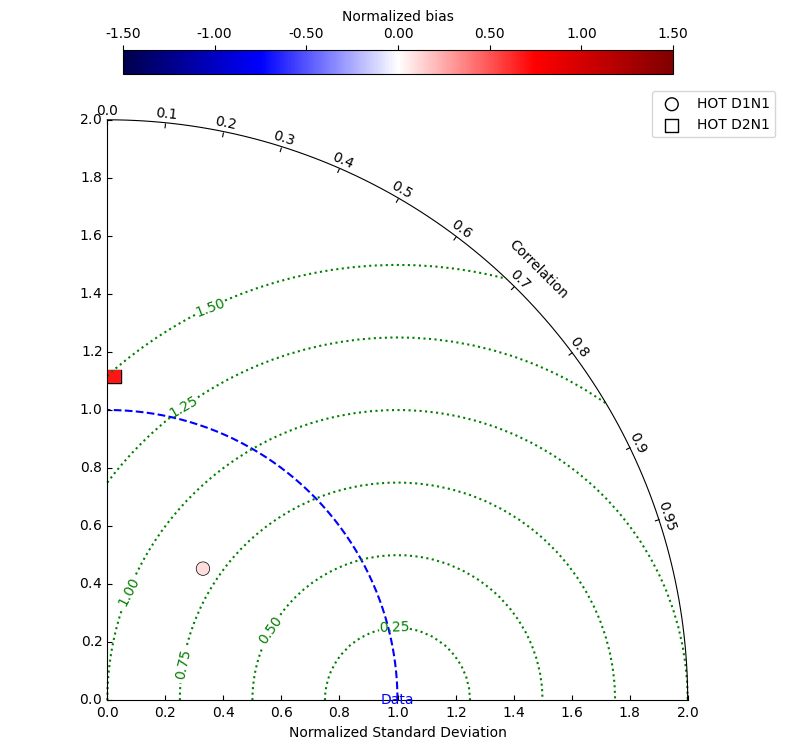

In [45]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_hot_plot_d1n1,
    biomass_hot_plot_d2n1,
]
all_obs = [
    obs_hot_plot_d1n1,
    obs_hot_plot_d2n1,
]

all_names = ["HOT D1N1", "HOT D2N1"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)

diagram.plot()

correlation [0.6229914442635573, 0.06313210943769332]
norm STD [0.5675041391259629, 1.4111974759332324]
bias [0.11327003826413307, 0.8847547368879654]
NRMSE [0.7841941732797045, 1.677287861132578]
name ['HOT D1N1', 'HOT D2N1']


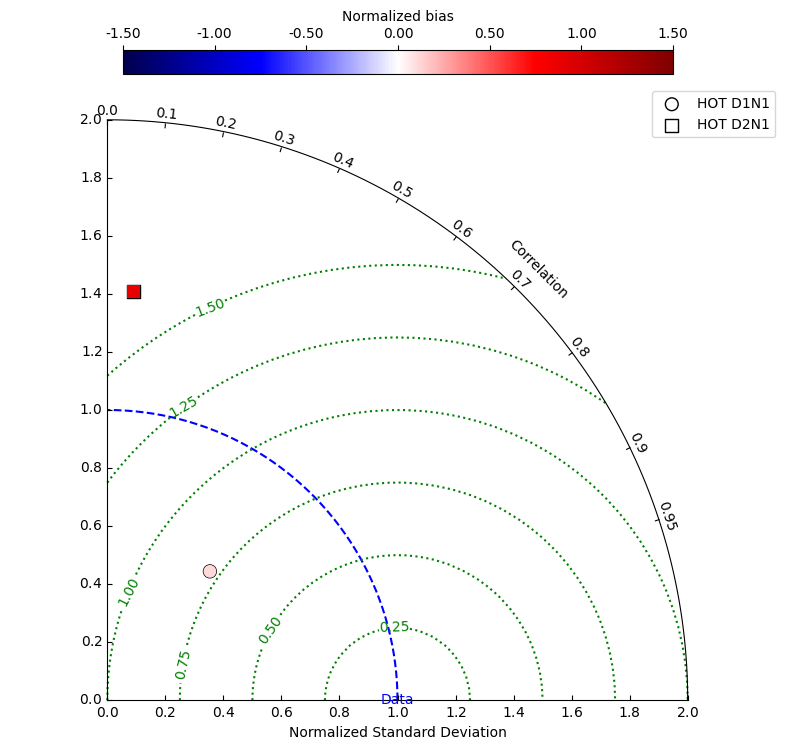

In [46]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_hot_plot_d1n1.resample("ME").mean(),
    biomass_hot_plot_d2n1.resample("ME").mean(),
]
all_obs = [
    obs_hot_plot_d1n1.resample("ME").mean(),
    obs_hot_plot_d2n1.resample("ME").mean(),
]

all_names = ["HOT D1N1", "HOT D2N1"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()